# Demonstrate the "target-decoy" approach, as applied to metagenomic variant calling

In [1]:
%run "Header.ipynb"

In [2]:
import copy
import json
import pickle
import skbio
import pileup
from math import ceil
from collections import defaultdict
from pysam import VariantFile
from parse_sco import parse_sco

In [3]:
seq2pos2pileup = pileup.load()

In [4]:
linesep_default = "-" * 79
def output_and_print(text, output_file, linesep=linesep_default):
    """Convenience function to both output something to a misc-text *.tex file and print it."""
    
    with open(output_file, "w") as of:
        # see https://tex.stackexchange.com/a/18018
        of.write("{}\endinput".format(text))
    
    print(linesep_default)
    print(f"Results that we just output to {output_file}:")
    print(linesep_default)
    print(text)

## Lower limit of $p$

Basically: since we only call a mutation at a given position `pos` using the naive method if `alt(pos) ≥ 2`, it doesn't make sense to use values of $p$ less than `2 / coverage` (coverage varies throughout a MAG, but let's use the rounded average coverage as the denominator here). So,

In [5]:
min_mean_cov = float("inf")
# This is copied from the SequenceCoveragePlots.ipynb notebook; easier to just duplicate the code for now, sorry!
seq2mean_cov = {}
for seq in SEQS:
    covs = []
    for pos in range(1, seq2len[seq] + 1):
        covs.append(pileup.get_cov(seq2pos2pileup[seq][pos]))
    mean_cov = mean(covs)
    seq2mean_cov[seq] = mean_cov
    min_mean_cov = min(mean_cov, min_mean_cov)
    print(f"The mean cov for seq {seq2name[seq]} is {mean_cov:,.2f}x.")
    
print(f"Across the three selected MAGs, the min mean cov is {min_mean_cov:,.2f}x.")

The mean cov for seq CAMP is 4,158.57x.
The mean cov for seq BACT1 is 1,415.07x.
The mean cov for seq BACT2 is 2,993.46x.
Across the three selected MAGs, the min mean cov is 1,415.07x.


In [6]:
# yeah yeah i know this is technically just 200 / min_mean_cov but clarity > performance imo and also this is
# just an analysis notebook
min_p = 100 * (2 / min_mean_cov)
print(f"So the lowest value of p it makes sense to use is p = 100 * (2 / {min_mean_cov:,.2f}) = {min_p:.4f}%.")

effective_min_p = ceil(min_p * 100) / 100
# I know .4f is unnecessary precision since we just rounded to a multiple of 0.01%,
# this is to sanity check that I did this right
print(f"Effective min p (taking the ceiling to the nearest 0.01%): {effective_min_p:.4f}%.")

avg_covs_info = (
    f"The average coverages of the three selected genomes are "
    f"{seq2mean_cov['edge_6104']:,.0f}x, {seq2mean_cov['edge_1671']:,.0f}x, and "
    f"{seq2mean_cov['edge_2358']:,.0f}x for the {seq2name['edge_6104']}, {seq2name['edge_1671']}, and "
    f"{seq2name['edge_2358']} genomes, respectively."
)
output_and_print(avg_covs_info, "misc-text/fdr-min-p-avg-covs.tex")
    
min_p_val_info = (
    f"We thus set the lower limit of $p$ as "
    r"$\frac{2}{"
    f"{seq2mean_cov['edge_1671']:,.2f}"
    r"} \approx "
    f"{min_p:.4f}\%$. Rounding this value up to the next largest "
    f"0.01\% gives us a lower limit $p$ of {effective_min_p:.2f}\%."
)
output_and_print(min_p_val_info, "misc-text/fdr-min-p-val.tex")

So the lowest value of p it makes sense to use is p = 100 * (2 / 1,415.07) = 0.1413%.
Effective min p (taking the ceiling to the nearest 0.01%): 0.1500%.
-------------------------------------------------------------------------------
Results that we just output to misc-text/fdr-min-p-avg-covs.tex:
-------------------------------------------------------------------------------
The average coverages of the three selected genomes are 4,159x, 1,415x, and 2,993x for the CAMP, BACT1, and BACT2 genomes, respectively.
-------------------------------------------------------------------------------
Results that we just output to misc-text/fdr-min-p-val.tex:
-------------------------------------------------------------------------------
We thus set the lower limit of $p$ as $\frac{2}{1,415.07} \approx 0.1413\%$. Rounding this value up to the next largest 0.01\% gives us a lower limit $p$ of 0.15\%.


## First: naive variant calling

We don't limit to "sufficiently-covered" positions here -- so we consider all regions throughout a genome.

In [7]:
# Percentages go from 5%, 4.99%, 4.98%, ..., min_p + 0.01%, min_p%.
# Since we draw FDR curves, etc. by varying p by 0.01%, we'll use a lower limit of ceil(min_p * 100) / 100.
# We limit the start here to 5% because the whole "rare mutations" definition means that we ignore p-mutations
# at higher values of p. Since this notebook is pretty inefficient, there's no point unnecessarily computing
# stuff for p = 50%, etc.
effective_min_p_times_100 = ceil(min_p * 100)
percentages = [p / 100 for p in range(effective_min_p_times_100, 500, 1)][::-1]
print(f"First two percentages: {percentages[:2]}")
print(f"Last two percentages: {percentages[-2:]}")
print(f"Number of percentages: {len(percentages):,}")

First two percentages: [4.99, 4.98]
Last two percentages: [0.16, 0.15]
Number of percentages: 485


In [8]:
def compute_num_mutations_per_mb(num_called_mutations_in_positions, num_positions_considered):
    # We have the equation
    #
    #      # called mutations              f
    # ---------------------------- = --------------
    #  # of positions to consider     1,000,000 bp
    #
    # This function just solves for f by multiplying the left side of the equation by 1,000,000.
    #
    # I guess if you're gonna be calling this thousands of time on the same set of positions
    # it might speed this up slightly to precompute the (1,000,000 / # of positions to consider) value,
    # but convenience is the most important thing here IMO.
    return (num_called_mutations_in_positions / num_positions_considered) * 1000000
    

def naive_calling(seq, positions_to_consider, verbose=True, superverbose=False):
    """seq should be in SEQS.
    
    positions_to_consider should be a collection of 1-indexed positions in the sequence to consider when
    calling mutations. This makes it possible to, for example, just consider the CP 2 positions in a sequence.
    
    Returns a tuple with three elements:
    
    1. p2called_mutations: A dict mapping values in "percentages" (defined above) to a list of 1-indexed
       "called" p-mutations in the positions to consider in the sequence, using this percentage for p.
       
    2. p2numpermb: A dict with the same keys as p2called_mutations, but the values are the number of called
       p-mutations per megabase (1,000,000 bp = 1 Mbp) in the positions to consider in this sequence.
       IT'S DEFINITELY WORTH NOTING that we scale this by the number of positions to consider, not the full
       sequence length (although it's possible that those values could be equal if positions_to_consider
       is equal to range(1, seq2len[seq] + 1)). So, if you select a subset of positions where most of them
       are mutations, this'll result in a really high number of mutations per megabase!
       ...I recognize "numpermb" doesn't really roll off the tongue, but I couldn't think
       of a better name for this :P
       
    3. poslen: Length of positions_to_consider, for reference.
    
    NOTE THAT this'll not include "high-frequency" mutations in the results, as discussed in the paper.
    We will not decrease poslen or anything -- positions with high-frequency mutations will just be
    treated as if they were non-mutated positions.
    """
    poslen = len(positions_to_consider)
    seqlen = seq2len[seq]
    positions_to_consider_pct = 100 * (poslen / seqlen)
    if verbose:
        print(f"Naively calling mutations in {seq2name[seq]}.")
        print(f"\tConsidering {poslen:,} / {seqlen:,} ({positions_to_consider_pct:.2f}%) positions.")
    p2called_mutations = {p: [] for p in percentages}
    p2numpermb = {}
    for pi, pos in enumerate(sorted(positions_to_consider), 1):
        if verbose and (pi == 1 or pi % 100000 == 0):
            print(f"\tOn the {pi:,}-th position ({pos:,}) of the specified {poslen:,} positions ({100 * (pi / poslen):.2f}%).")
        pos_pileup = seq2pos2pileup[seq][pos]
        for p in percentages:
            # Note that this includes the min alt(pos) check made by naively_call_mutation() (see docs there)
            # as well as the only-calling-if-rare thing
            if pileup.naively_call_mutation(pos_pileup, p, only_call_if_rare=True):
                p2called_mutations[p].append(pos)

    for p in p2called_mutations:
        num_called_mutations = len(p2called_mutations[p])
        p2numpermb[p] = compute_num_mutations_per_mb(num_called_mutations, poslen)
        # We add an extra layer of verbosity here because printing out 2 lines per value of p gets
        # ridiculous when there are 1,000 values of p .____.
        if superverbose:
            print(f"\tp = {p}%: {num_called_mutations:,} called p-mutations in {seq2name[seq]}.")
            print(f"\t\tNumber of called p-mutations per megabase: f = {f:,.2f}.")
        
    return (p2called_mutations, p2numpermb, poslen)


def naive_calling_fullseq(seq):
    """Does naive variant calling across all positions in a sequence (should be in SEQS)."""
    return naive_calling(seq, range(1, seq2len[seq] + 1))


def get_single_gene_cp2_positions(seq):
    cp2_positions = set()
    multi_gene_positions = set()
    
    seqlen = seq2len[seq]
    genes_df = parse_sco(f"../seqs/genes/{seq}.sco")
    
    # Code here is adapted from get_parent_gene_info_of_many_positions (in Header.ipynb) a bit
    # Faster to compute everything at once, rather than iterate through the genes multiple times
    pos_to_genes = defaultdict(list)
    
    for gene in genes_df.itertuples():
        gene_left = int(gene.LeftEnd)
        gene_right = int(gene.RightEnd)
        gene_num = int(gene.Index)
        gene_strand = gene.Strand
        
        def complainAboutCPs(gn, gs, gcp):
            raise ValueError(f"CP got out of whack: gene {gn}, strand {gs}, cp {gcp}?")
        
        if gene_strand == "+":
            cp = 1
        else:
            cp = 3
        
        for pos in range(gene_left, gene_right + 1):
            pos_to_genes[pos].append(gene_num)
            if len(pos_to_genes[pos]) > 1:
                multi_gene_positions.add(pos)
                
            if cp == 2:
                cp2_positions.add(pos)
                
            # Adjust the CP. I already have some code that does this (in a different context) in the within-
            # gene mutation spectrum notebook; ideally this code would be generalized between the notebooks.
            if gene_strand == "+":
                # For + strand genes, this goes 123123123123...
                if cp == 1 or cp == 2: cp += 1
                elif cp == 3: cp = 1
                else: complainAboutCPs(gene_num, gene_strand, cp)
            else:
                # For - strand genes, this goes 321321321321...
                if cp == 3 or cp == 2: cp -= 1
                elif cp == 1: cp = 3
                else: complainAboutCPs(gene_num, gene_strand, cp)
    
    single_gene_cp2_positions = cp2_positions - multi_gene_positions
    return single_gene_cp2_positions
    

def naive_calling_cp2seq(seq):
    """Does naive variant calling across just the CP 2 positions in a sequence (should be in SEQS).
    
    NOTE that this will filter only to positions that meet the exact criteria:
    
    - In a single gene (not in a position that is covered by overlapping genes).
    - In CP 2 within this single gene.
    
    Even if a position is in CP 2 of all the multiple genes it's covered by, we'll still ignore it.
    I'm pretty sure there should be very few positions that get tossed out as a result; my take is that
    it isn't worth the trouble to try to handle these positions.
    """

    print(f"Identifying CP 2 positions in {seq2name[seq]} so we can use them as a decoy genome...")
    single_gene_cp2_positions = get_single_gene_cp2_positions(seq)
    print(f"In {seq2name[seq]}:")
    #print(f"\tThere were {len(cp2_positions):,} CP 2 positions.")
    #print(f"\tThere were {len(multi_gene_positions):,} positions in multiple genes.")
    print(f"\tThere were {len(single_gene_cp2_positions):,} CP 2 positions in only a single gene.")
    return naive_calling(seq, single_gene_cp2_positions)

### Naively call mutations in CAMP and compute $\mathrm{frac}_{\mathrm{decoy}}$

(We're treating CAMP as a "decoy" genome, where we assume that all called mutations within it will be incorrect.)

In [8]:
camp_naive_p2called_mutations, camp_naive_p2numpermb, _ = naive_calling_fullseq("edge_6104")

Naively calling mutations in CAMP.
	Considering 1,289,244 / 1,289,244 (100.00%) positions.
	On the 1-th position (1) of the specified 1,289,244 positions (0.00%).
	On the 100,000-th position (100,000) of the specified 1,289,244 positions (7.76%).
	On the 200,000-th position (200,000) of the specified 1,289,244 positions (15.51%).
	On the 300,000-th position (300,000) of the specified 1,289,244 positions (23.27%).
	On the 400,000-th position (400,000) of the specified 1,289,244 positions (31.03%).
	On the 500,000-th position (500,000) of the specified 1,289,244 positions (38.78%).
	On the 600,000-th position (600,000) of the specified 1,289,244 positions (46.54%).
	On the 700,000-th position (700,000) of the specified 1,289,244 positions (54.30%).
	On the 800,000-th position (800,000) of the specified 1,289,244 positions (62.05%).
	On the 900,000-th position (900,000) of the specified 1,289,244 positions (69.81%).
	On the 1,000,000-th position (1,000,000) of the specified 1,289,244 posi

In [9]:
camp_cp2_naive_p2called_mutations, camp_cp2_naive_p2numpermb, num_camp_cp2_pos = naive_calling_cp2seq("edge_6104")

Identifying CP 2 positions in CAMP so we can use them as a decoy genome...
In CAMP:
	There were 394,850 CP 2 positions in only a single gene.
Naively calling mutations in CAMP.
	Considering 394,850 / 1,289,244 (30.63%) positions.
	On the 1-th position (267) of the specified 394,850 positions (0.00%).
	On the 100,000-th position (325,447) of the specified 394,850 positions (25.33%).
	On the 200,000-th position (651,427) of the specified 394,850 positions (50.65%).
	On the 300,000-th position (977,868) of the specified 394,850 positions (75.98%).


### For comparison, naively call mutations in BACT1 and compute $\mathrm{frac}_{\mathrm{BACT1}}$

In [10]:
bact1_naive_p2called_mutations, bact1_naive_p2numpermb, _ = naive_calling_fullseq("edge_1671")

Naively calling mutations in BACT1.
	Considering 2,153,394 / 2,153,394 (100.00%) positions.
	On the 1-th position (1) of the specified 2,153,394 positions (0.00%).
	On the 100,000-th position (100,000) of the specified 2,153,394 positions (4.64%).
	On the 200,000-th position (200,000) of the specified 2,153,394 positions (9.29%).
	On the 300,000-th position (300,000) of the specified 2,153,394 positions (13.93%).
	On the 400,000-th position (400,000) of the specified 2,153,394 positions (18.58%).
	On the 500,000-th position (500,000) of the specified 2,153,394 positions (23.22%).
	On the 600,000-th position (600,000) of the specified 2,153,394 positions (27.86%).
	On the 700,000-th position (700,000) of the specified 2,153,394 positions (32.51%).
	On the 800,000-th position (800,000) of the specified 2,153,394 positions (37.15%).
	On the 900,000-th position (900,000) of the specified 2,153,394 positions (41.79%).
	On the 1,000,000-th position (1,000,000) of the specified 2,153,394 posi

### Just so we can update the `misc-text/` file, also do this for  BACT2

probs possible to get this info from another notebook but this is the easiest way to handle this imo

In [11]:
bact2_naive_p2called_mutations, bact2_naive_p2numpermb, _ = naive_calling_fullseq("edge_2358")

Naively calling mutations in BACT2.
	Considering 2,806,161 / 2,806,161 (100.00%) positions.
	On the 1-th position (1) of the specified 2,806,161 positions (0.00%).
	On the 100,000-th position (100,000) of the specified 2,806,161 positions (3.56%).
	On the 200,000-th position (200,000) of the specified 2,806,161 positions (7.13%).
	On the 300,000-th position (300,000) of the specified 2,806,161 positions (10.69%).
	On the 400,000-th position (400,000) of the specified 2,806,161 positions (14.25%).
	On the 500,000-th position (500,000) of the specified 2,806,161 positions (17.82%).
	On the 600,000-th position (600,000) of the specified 2,806,161 positions (21.38%).
	On the 700,000-th position (700,000) of the specified 2,806,161 positions (24.95%).
	On the 800,000-th position (800,000) of the specified 2,806,161 positions (28.51%).
	On the 900,000-th position (900,000) of the specified 2,806,161 positions (32.07%).
	On the 1,000,000-th position (1,000,000) of the specified 2,806,161 posi

### Save this info to text files using the json module

... Since recomputing this takes, like, an hour

In [12]:
with open("misc-output/p2called_mutations.txt", "w") as p2cmf:
    for p2cm in (
        camp_naive_p2called_mutations, camp_cp2_naive_p2called_mutations,
        bact1_naive_p2called_mutations, bact2_naive_p2called_mutations
    ):
        p2cmf.write(json.dumps(p2cm))
        p2cmf.write("\n")

In [13]:
with open("misc-output/p2numpermb.txt", "w") as p2nf:
    for p2n in (
        camp_naive_p2numpermb, camp_cp2_naive_p2numpermb,
        bact1_naive_p2numpermb, bact2_naive_p2numpermb
    ):
        p2nf.write(json.dumps(p2n))
        p2nf.write("\n")

### Load naive calling info from text files

In [9]:
with open("misc-output/p2called_mutations.txt", "r") as p2cmf:
    camp_naive_p2called_mutations = json.loads(p2cmf.readline().strip())
    camp_cp2_naive_p2called_mutations = json.loads(p2cmf.readline().strip())
    bact1_naive_p2called_mutations = json.loads(p2cmf.readline().strip())
    bact2_naive_p2called_mutations = json.loads(p2cmf.readline().strip())
    
with open("misc-output/p2numpermb.txt", "r") as p2nf:
    camp_naive_p2numpermb = json.loads(p2nf.readline().strip())
    camp_cp2_naive_p2numpermb = json.loads(p2nf.readline().strip())
    bact1_naive_p2numpermb = json.loads(p2nf.readline().strip())
    bact2_naive_p2numpermb = json.loads(p2nf.readline().strip())

In [10]:
# If we haven't done naive calling yet, we gotta compute this number also so we can use this in figures, etc.
# And knowing the CP 2 positions anyway is needed for the LoFreq stuff.
camp_cp2_pos = get_single_gene_cp2_positions("edge_6104")
num_camp_cp2_pos = len(camp_cp2_pos)
print(f"There are {num_camp_cp2_pos:,} CP 2 single-gene positions in CAMP.")

There are 394,850 CP 2 single-gene positions in CAMP.


### Output info about FDR estimation for $p=0.5\%$ to `misc-text/`

**NOTE: this only includes "rare" (i.e. not high-frequency, as defined above) mutations.**

In [34]:
# Total numbers of identified p-mutations
camp_nump = len(camp_naive_p2called_mutations["0.5"])
bact1_nump = len(bact1_naive_p2called_mutations["0.5"])
bact2_nump = len(bact2_naive_p2called_mutations["0.5"])
# Scaled numbers of identified p-mutations per megabase (comparable across different-length genomes
# [at least, if you assume that genome length is the only confounding factor here, which it isn't -- we
# should mention this in the paper ofc])
camp_numpermb = camp_naive_p2numpermb["0.5"]
bact1_numpermb = bact1_naive_p2numpermb["0.5"]
bact2_numpermb = bact2_naive_p2numpermb["0.5"]

bact1_fdr = 100 * (camp_numpermb / bact1_numpermb)

naiveinfo = (
    f"At $p=0.5$\\%, NaiveFreq identified {camp_nump:,}, {bact1_nump:,}, and {bact2_nump:,} rare $p$-mutations "
    f"in the {seq2name['edge_6104']}, {seq2name['edge_1671']}, and {seq2name['edge_2358']} genomes, "
    f"respectively. This illustrates that there exists a difference of nearly two orders of magnitude "
    f"in the number of rare $p$-mutations per megabase across these genomes "
    f"({round(camp_numpermb):,}, {round(bact1_numpermb):,}, and {round(bact2_numpermb):,} for "
    f"{seq2name['edge_6104']}, {seq2name['edge_1671']}, and {seq2name['edge_2358']}, respectively). "
    f"If the {seq2name['edge_6104']} genome, which has a relatively low mutation rate, is "
    f"selected as a decoy, then we estimate the FDR for the {seq2name['edge_1671']} genome at $p=0.5\\%$ as "
    "$\\frac{" + f"{round(camp_numpermb):,}" + "}" + "{" + f"{round(bact1_numpermb):,}" + "}" + f" \\approx {bact1_fdr:.2f}\\%$."
)

output_and_print(naiveinfo, "misc-text/naive-calling-target-decoy.tex")

-------------------------------------------------------------------------------
Results that we just output to misc-text/naive-calling-target-decoy.tex:
-------------------------------------------------------------------------------
At $p=0.5$\%, NaiveFreq identified 249, 17,069, and 1,632 rare $p$-mutations in the CAMP, BACT1, and BACT2 genomes, respectively. This illustrates that there exists a difference of nearly two orders of magnitude in the number of rare $p$-mutations per megabase across these genomes (193, 7,927, and 582 for CAMP, BACT1, and BACT2, respectively). If the CAMP genome, which has a relatively low mutation rate, is selected as a decoy, then we estimate the FDR for the BACT1 genome at $p=0.5\%$ as $\frac{193}{7,927} \approx 2.44\%$.


In [36]:
bact1_fdr_using_camp = 100 * (camp_naive_p2numpermb["0.5"] / bact1_naive_p2numpermb["0.5"])
bact1_fdr_using_campcp2 = 100 * (camp_cp2_naive_p2numpermb["0.5"] / bact1_naive_p2numpermb["0.5"])
cp2info = (
    "For example, at the frequency threshold $p=0.5$\%, there are only "
    f"{len(camp_cp2_naive_p2called_mutations['0.5']):,} rare $p$-mutations in CP2 in the {seq2name['edge_6104']} "
    f"genome, resulting in {round(camp_cp2_naive_p2numpermb['0.5']):,} mutations per megabase of the CP2 "
    f"positions (as compared to {round(camp_naive_p2numpermb['0.5']):,} for the entire {seq2name['edge_6104']} genome). "
    f"Therefore, the estimate of the FDR for called mutations in the {seq2name['edge_1671']} genome "
    f"can now be reduced from {bact1_fdr_using_camp:.2f}\\% to {bact1_fdr_using_campcp2:.2f}\\%."
)

output_and_print(cp2info, "misc-text/camp-cp2-fdr.tex")

-------------------------------------------------------------------------------
Results that we just output to misc-text/camp-cp2-fdr.tex:
-------------------------------------------------------------------------------
For example, at the frequency threshold $p=0.5$\%, there are only 52 rare $p$-mutations in CP2 in the CAMP genome, resulting in 132 mutations per megabase of the CP2 positions (as compared to 193 for the entire CAMP genome). Therefore, the estimate of the FDR for called mutations in the BACT1 genome can now be reduced from 2.44\% to 1.66\%.


### Load LoFreq calls, and output info about FDR estimation for LoFreq to `misc-text/`

#### Load LoFreq VCF info and compute various things

**NOTE: this still only includes "rare" (i.e. not high-frequency, as defined above) mutations.** LoFreq can call either type of mutations, but we explicitly filter out high-frequency mutations here to make its calls comparable with the naive ones above.

In [12]:
# Load LoFreq info
lofreq_calls = VariantFile("../seqs/lofreq.vcf")

# Record raw numbers of called mutations from LoFreq
camp_lofreq_mutations = set()
camp_cp2_lofreq_mutations = set()
bact1_lofreq_mutations = set()
bact2_lofreq_mutations = set()

# (and these things, which we'll use to plot an FDR curve)
# NOTE: this code is gross and duplicated because it's 7pm on a friday, should make better
bact1_lofreq_p2num_called_mutations_i = {p: 0 for p in percentages}
bact1_lofreq_p2numpermb = {}
camp_lofreq_p2num_called_mutations_i = {p: 0 for p in percentages}
camp_lofreq_p2numpermb = {}
camp_cp2_lofreq_p2num_called_mutations_i = {p: 0 for p in percentages}
camp_cp2_lofreq_p2numpermb = {}

total_bact1_called_variants = 0

for c in lofreq_calls.fetch():
    
    if pileup.is_position_rare(seq2pos2pileup[c.contig][c.pos]):
        if c.contig == "edge_6104":
            camp_lofreq_mutations.add(c.pos)
            if c.pos in camp_cp2_pos:
                camp_cp2_lofreq_mutations.add(c.pos)

        elif c.contig == "edge_1671":
            bact1_lofreq_mutations.add(c.pos)
            total_bact1_called_variants += 1

        elif c.contig == "edge_2358":
            bact2_lofreq_mutations.add(c.pos)

print(f"According to LoFreq, there are {len(camp_lofreq_mutations):,} rare mutations in CAMP.")
print(f"... and {len(camp_cp2_lofreq_mutations):,} rare mutations in CAMP CP 2.")
print(f"... and {len(bact1_lofreq_mutations):,} rare mutations in BACT1.")
print(f"... and {len(bact2_lofreq_mutations):,} rare mutations in BACT2.")

if total_bact1_called_variants != len(bact1_lofreq_mutations):
    print("-" * 79)
    print(
        f"NOTE: There were actually {total_bact1_called_variants:,} variants total in BACT1 -- due to some\n"
        "variants being called at the same position. The code accounts for this, don't worry."
    )
    print("-" * 79)

print("Being slow and assigning p2num_called_mutations_i for BACT1 and CAMP based on LoFreq...")
# NOTE: iterating lazily over all percentages is a very terrible, slow way to do this.
# Possible to make it much faster if we sort the percentages in advance, probs...
# if this is a bottleneck for you please go send marcus an angry email, sorry 2021 is a rough year
for p in percentages:
    # consider each UNIQUE position with a called variant -- positions with > 1 called variant will
    # only get one pass in this loop. this is intentional.
    #
    # so basically, if you're me in a year and you're like "what is this code even doing", the idea is
    # that a given point in the FDR curve only includes variants with mutation frequency >= that point,
    # since we're adjusting "p" to create this FDR curve. This is essentially* the same as how the naive
    # mutation calling works, so we can reuse that on the LoFreq calls, if this isn't too convoluted.
    # (we could also use the reported AF [allele frequency] from LoFreq instead of the pileup thing, but
    # i figure we may as well be consistent since we're collapsing things to single positions anyway.)
    #
    # *we use min_alt_pos = 0 here because that's only used when filtering naive calling, and these
    # calls are from LoFreq -- so we're just varying them based on alt(pos) while ignoring the other stuff.
    for pos in bact1_lofreq_mutations:
        if pileup.naively_call_mutation(seq2pos2pileup["edge_1671"][pos], p, min_alt_pos=0):
            bact1_lofreq_p2num_called_mutations_i[p] += 1
            
    # same as above
    for pos in camp_lofreq_mutations:
        if pileup.naively_call_mutation(seq2pos2pileup["edge_6104"][pos], p, min_alt_pos=0):
            camp_lofreq_p2num_called_mutations_i[p] += 1
            
    for pos in camp_cp2_lofreq_mutations:
        if pileup.naively_call_mutation(seq2pos2pileup["edge_6104"][pos], p, min_alt_pos=0):
            camp_cp2_lofreq_p2num_called_mutations_i[p] += 1
        
print("Phew, done with that.")

# Compute numbers of mutations per megabase
camp_lofreq_numpermb = compute_num_mutations_per_mb(len(camp_lofreq_mutations), seq2len["edge_6104"])
camp_cp2_lofreq_numpermb = compute_num_mutations_per_mb(len(camp_cp2_lofreq_mutations), num_camp_cp2_pos)
bact1_lofreq_numpermb = compute_num_mutations_per_mb(len(bact1_lofreq_mutations), seq2len["edge_1671"])
bact2_lofreq_numpermb = compute_num_mutations_per_mb(len(bact2_lofreq_mutations), seq2len["edge_2358"])

# Create p2num_called_mutations for BACT1 using LoFreq.
for p in percentages:
    bact1_num_called_mutations = bact1_lofreq_p2num_called_mutations_i[p]
    bact1_lofreq_p2numpermb[str(p)] = compute_num_mutations_per_mb(bact1_num_called_mutations, seq2len["edge_1671"])
    
    camp_num_called_mutations = camp_lofreq_p2num_called_mutations_i[p]
    camp_lofreq_p2numpermb[str(p)] = compute_num_mutations_per_mb(camp_num_called_mutations, seq2len["edge_6104"])
    
    camp_cp2_num_called_mutations = camp_cp2_lofreq_p2num_called_mutations_i[p]
    camp_cp2_lofreq_p2numpermb[str(p)] = compute_num_mutations_per_mb(camp_cp2_num_called_mutations, num_camp_cp2_pos)

# Compute FDRs!
bact1_fdr_lofreq_camp_decoy = 100 * (camp_lofreq_numpermb / bact1_lofreq_numpermb)
bact1_fdr_lofreq_camp_cp2_decoy = 100 * (camp_cp2_lofreq_numpermb / bact1_lofreq_numpermb)
bact2_fdr_lofreq_camp_decoy = 100 * (camp_lofreq_numpermb / bact2_lofreq_numpermb)
bact2_fdr_lofreq_camp_cp2_decoy = 100 * (camp_cp2_lofreq_numpermb / bact2_lofreq_numpermb)
print(
    "Just using the LoFreq calls, the FDR for BACT1 using CAMP as a decoy is "
    f"{bact1_fdr_lofreq_camp_decoy:.2f}%."
)
print(
    "Just using the LoFreq calls, the FDR for BACT1 using CAMP CP 2 as a decoy is "
    f"{bact1_fdr_lofreq_camp_cp2_decoy:.2f}%."
)
print(
    "Just using the LoFreq calls, the FDR for BACT2 using CAMP as a decoy is "
    f"{bact2_fdr_lofreq_camp_decoy:.2f}%."
)
print(
    "Just using the LoFreq calls, the FDR for BACT2 using CAMP CP 2 as a decoy is "
    f"{bact2_fdr_lofreq_camp_cp2_decoy:.2f}%."
)

According to LoFreq, there are 22 rare mutations in CAMP.
... and 4 rare mutations in CAMP CP 2.
... and 9,641 rare mutations in BACT1.
... and 79 rare mutations in BACT2.
-------------------------------------------------------------------------------
NOTE: There were actually 9,674 variants total in BACT1 -- due to some
variants being called at the same position. The code accounts for this, don't worry.
-------------------------------------------------------------------------------
Being slow and assigning p2num_called_mutations_i for BACT1 and CAMP based on LoFreq...
Phew, done with that.
Just using the LoFreq calls, the FDR for BACT1 using CAMP as a decoy is 0.38%.
Just using the LoFreq calls, the FDR for BACT1 using CAMP CP 2 as a decoy is 0.23%.
Just using the LoFreq calls, the FDR for BACT2 using CAMP as a decoy is 60.61%.
Just using the LoFreq calls, the FDR for BACT2 using CAMP CP 2 as a decoy is 35.98%.


#### Compute naïve mutation calling info for $p = 2\%$ mutations

Because it turns out these are pretty similar to what LoFreq calls.

In [13]:
nc2 = camp_naive_p2called_mutations["2.0"]
nb12 = bact1_naive_p2called_mutations["2.0"]
nb22 = bact2_naive_p2called_mutations["2.0"]

fdr_num_n2 = camp_naive_p2numpermb["2.0"]
fdr_den_n2 = bact1_naive_p2numpermb["2.0"]
fdr_n2 = 100 * (fdr_num_n2 / fdr_den_n2)
print(f"Estimated BACT1 FDR at p = 2% is {fdr_num_n2:,.2f} / {fdr_den_n2:,.2f} = {fdr_n2:.2f}%")

seq2naive2ct = {}
seq2overlapct = {}
for seq, naive_2pct_muts, lf_muts in (
    ("edge_6104", nc2, camp_lofreq_mutations),
    ("edge_1671", nb12, bact1_lofreq_mutations),
    ("edge_2358", nb22, bact2_lofreq_mutations)
):
    # Print out info to prove to myself that yes, p=2% and LoFreq are pretty similar!
    nl = len(naive_2pct_muts)
    ll = len(lf_muts)
    print(f"{seq2name[seq]} has {nl:,} p = 2% p-mutations and {ll:,} LoFreq-called mutations.")
    naive_lf_overlap = set(naive_2pct_muts) & set(lf_muts)
    ol = len(naive_lf_overlap)
    print(f"\tNumber of overlapping calls btwn (naive calling at p=2%) and (LoFreq): {ol:,}")
    print(f"\tPercentage of (Overlap / LoFreq): {100 * (ol / ll):.2f}%")
    
    # ... Save this info to dicts to make it easy to output in the misc text notebook below.
    # I guess we could do that here instead but, uh, whatever, no reason to make this more complicated
    # than it already is. I don't think we have enough coffee for that.
    seq2naive2ct[seq] = nl
    seq2overlapct[seq] = ol

Estimated BACT1 FDR at p = 2% is 13.19 / 4,885.31 = 0.27%
CAMP has 17 p = 2% p-mutations and 22 LoFreq-called mutations.
	Number of overlapping calls btwn (naive calling at p=2%) and (LoFreq): 15
	Percentage of (Overlap / LoFreq): 68.18%
BACT1 has 10,520 p = 2% p-mutations and 9,641 LoFreq-called mutations.
	Number of overlapping calls btwn (naive calling at p=2%) and (LoFreq): 8,033
	Percentage of (Overlap / LoFreq): 83.32%
BACT2 has 100 p = 2% p-mutations and 79 LoFreq-called mutations.
	Number of overlapping calls btwn (naive calling at p=2%) and (LoFreq): 43
	Percentage of (Overlap / LoFreq): 54.43%


In [38]:
# Output info -- analogous to the naive info output above.
# ... BUT WITH MORE STUFF since we're comparing LoFreq to the naive method at p=2%
lf_camp_num = len(camp_lofreq_mutations)
lf_bact1_num = len(bact1_lofreq_mutations)
lf_bact2_num = len(bact2_lofreq_mutations)

# Just because we use this a lot...!
seqnames = f"{seq2name['edge_6104']}, {seq2name['edge_1671']}, and {seq2name['edge_2358']}"

# PART 1: LoFreq vs. 2% calls comparison
lfinfo = (
    f"LoFreq called {lf_camp_num:,}, {lf_bact1_num:,}, and {lf_bact2_num:,} rare mutations "
    f"in the {seqnames} genomes, "
    f"respectively. At the frequency threshold $p = 2\%$, NaiveFreq "
    r'called a similar number of rare $p$-mutations '
    f"({seq2naive2ct['edge_6104']:,}, {seq2naive2ct['edge_1671']:,}, and {seq2naive2ct['edge_2358']:,} for "
    f"{seqnames}, respectively). It turns out that the sets of rare mutations identified by LoFreq and by "
    r'NaiveFreq at $p = 2\%$ are similar: the numbers of overlapping rare mutations between these '
    f"groups are {seq2overlapct['edge_6104']:,}, {seq2overlapct['edge_1671']:,}, and "
    f"{seq2overlapct['edge_2358']:,} for {seqnames}. This suggests that, at least for this dataset, "
    f"LoFreq primarily detected rare mutations with frequency of at least 2\%. Here, we describe an analysis of "
    f"FDRs which suggests that there exist many more lower-frequency rare mutations.\n\n"
)

# PART 2: LoFreq vs. 2% calls FDR: BACT2
lfinfo += (
    f"Using LoFreq's calls, the numbers of rare mutations per megabase for each genome are "
    f"{round(camp_lofreq_numpermb):,}, {round(bact1_lofreq_numpermb):,}, and {round(bact2_lofreq_numpermb):,} "
    f"for {seq2name['edge_6104']}, {seq2name['edge_1671']}, and {seq2name['edge_2358']}, respectively. "
    f"We can estimate the FDR of LoFreq's calls for the {seq2name['edge_2358']} genome (using the "
    f"{seq2name['edge_6104']} genome as a decoy) as "
    "$\\frac{"
    f"{round(camp_lofreq_numpermb):,}"
    "}{"
    f"{round(bact2_lofreq_numpermb):,}"
    "}"
    f" \\approx {bact2_fdr_lofreq_camp_decoy:.2f}\\%$, a very large FDR, indicating that either most identified "
    f"mutations are false or that selection of the {seq2name['edge_6104']} genome as the decoy results in a "
    f"highly inflated estimate of the FDR. Although NaiveFreq's calls at the frequency threshold $p = 2\\%$ "
    f"resulted in a lower estimated FDR of "
    "$\\frac{"
    f"{round(camp_naive_p2numpermb['2.0']):,}"
    "}{"
    f"{round(bact2_naive_p2numpermb['2.0']):,}"
    "}"
    f" \\approx {100 * (camp_naive_p2numpermb['2.0'] / bact2_naive_p2numpermb['2.0']):.2f}\\%$ "
    f"for the {seq2name['edge_2358']} genome, this is still a high FDR that raises concerns about downstream "
    f"analyses such as phasing.\n\n"
)

# PART 3: LoFreq FDR: BACT1
lfinfo += (
    f"On the other hand, the estimated FDR of LoFreq's calls for the {seq2name['edge_1671']} genome (still "
    f"using the {seq2name['edge_6104']} genome as a decoy) is only "
    "$\\frac{"
    f"{round(camp_lofreq_numpermb):,}"
    "}{"
    f"{round(bact1_lofreq_numpermb):,}"
    "} "
    f"\\approx {bact1_fdr_lofreq_camp_decoy:.2f}\\%$; "
)
# PART 4: 2% FDR: BACT1
lfinfo += (
    r"NaiveFreq at the frequency threshold of $p = 2\%$ has a slightly lower estimated FDR of "
    "$\\frac{"
    f"{round(fdr_num_n2):,}"
    "}{"
    f"{round(fdr_den_n2):,}"
    "} "
    f"\\approx {fdr_n2:.2f}\\%$. "
    r'Although both LoFreq and NaiveFreq at $p = 2\%$ result in the reliable identification of '
    "rare mutations with low FDR, we are still interested in extending the set of identified rare mutations while "
    r'controlling the FDR. For example, lowering the frequency threshold of NaiveFreq to '
    f"$p = 0.5\%$ results in the identification of {len(bact1_naive_p2called_mutations['0.5']):,} rare mutations in the "
    f"{seq2name['edge_1671']} genome (an additional "
    f"{len(bact1_naive_p2called_mutations['0.5']) - seq2naive2ct['edge_1671']:,} rare mutations as compared to $p = 2\%$) "
    "with a higher but still relatively low FDR estimate of "
    f"{100 * (camp_naive_p2numpermb['0.5'] / bact1_naive_p2numpermb['0.5']):.2f}\\%."
)

output_and_print(lfinfo, "misc-text/lofreq-target-decoy.tex")

-------------------------------------------------------------------------------
Results that we just output to misc-text/lofreq-target-decoy.tex:
-------------------------------------------------------------------------------
LoFreq called 22, 9,641, and 79 rare mutations in the CAMP, BACT1, and BACT2 genomes, respectively. At the frequency threshold $p = 2\%$, NaiveFreq called a similar number of rare $p$-mutations (17, 10,520, and 100 for CAMP, BACT1, and BACT2, respectively). It turns out that the sets of rare mutations identified by LoFreq and by NaiveFreq at $p = 2\%$ are similar: the numbers of overlapping rare mutations between these groups are 15, 8,033, and 43 for CAMP, BACT1, and BACT2. This suggests that, at least for this dataset, LoFreq primarily detected rare mutations with frequency of at least 2\%. Here, we describe an analysis of FDRs which suggests that there exist many more lower-frequency rare mutations.

Using LoFreq's calls, the numbers of rare mutations per megab

## Plot estimated BACT1 FDR vs. scaled number of identified (rare) mutations

Previous versions of this notebook only drew one FDR curve at a time; now, this function accepts multiple decoy genome `p2numpermb` objects.

In [15]:
DECOY_CAMP_COLOR = "#008800"
DECOY_CAMP_CP2_COLOR = cp2color[2]

In [16]:
def plot_bact1_fdr(
    target_p2numpermb, decoy_p2numpermbs, colors, shapes, decoy_labels, fig_basename,
    use_log=True, start_p=None, end_p=None, show_p_labels=False,
    special_p_markers=[2, 0.22, 0.15],
    titleprefix=f"{seq2name['edge_1671']} FDR curves based on na\u00efve rare $p$-mutation calling"
):
    """Plots FDR curves with some fancy annotations.
    
    target_p2numpermb is analogous to bact1_naive_p2numpermb. This maps values of p (some percentage
    that you're using as a cutoff for calling mutations) to the number of called mutations per megabase
    for some genome. (This is currently assumed to be BACT1, because of e.g. the title we use for this
    figure, but really you could draw these sorta curves for any genome that you have variant calls for.)
    
    decoy_p2numpermbs, colors, shapes, and decoy_labels should all be collections of identical length
    (this lets you pass in and style multiple decoy genomes to be shown on the same plot). So, for example,
    you can show how different decoy genomes result in different FDR curves for the same target genome.
    """
    
    fig, ax = pyplot.subplots(1)
    
    for di, decoy_p2numpermb in enumerate(decoy_p2numpermbs):
        if start_p is None:
            start_p = percentages[0]
        
        if end_p is None:
            end_p = percentages[-1]
        
        # This is all the percentages we HOPE to use
        attempting_to_use_percentages = percentages[percentages.index(start_p) : percentages.index(end_p) + 1]
        # This is all the percentages we CAN use (the FDR is d/t, so if t is 0 then we can't show that FDR...)
        used_percentages = []
        
        p2bact1fdr = {}
        for p in attempting_to_use_percentages:
            d = decoy_p2numpermb[str(p)]
            t = target_p2numpermb[str(p)]
            if t != 0:
                p2bact1fdr[p] = 100 * (d / t)
                used_percentages.append(p)
            
        # FDR
        x = []
        # number of mutations per megabase
        y = []
        # list of 2-tuples of (x,y). we'll highlight these points.
        special_xys = []
        for p in used_percentages:
            cx = p2bact1fdr[p]
            cy = target_p2numpermb[str(p)]
            x.append(cx)
            y.append(cy)
            if show_p_labels:
                # add labels (manually positioned). yeah, i know i know
                # we only show these labels once per plot (to avoid the text overlapping itself
                # from doing this multiple times)
                dy = None
                dx = None
                if use_log:
                    if p == 2: dy = -500; dx = 0.005
                    elif p == 0.22: dy = -4000; dx = -0.008
                    elif p == 0.15: dy = -6000; dx = -0.008
                else:
                    if p == 2: dy = 0; dx = 0.005
                    elif p == 0.22: dy = -200; dx = 0.005
                    elif p == 0.15: dy = 300; dx = -0.008
                    
                if dy is not None:
                    if p >= 1:
                        text = f"$p = {p:.0f}\%$"
                    elif p >= 0.5:
                        text = f"$p = {p:.1f}\%$"
                    else:
                        text = f"$p = {p:.2f}\%$"
                    if di == 0:
                        ax.text(cx + dx, cy + dy, text)
                        
            if p in special_p_markers:
                special_xys.append((cx, cy))

        ax.plot(x, y, marker=shapes[di], color=colors[di], label=decoy_labels[di])
        if len(special_xys) > 0:
            ax.scatter([xy[0] for xy in special_xys], [xy[1] for xy in special_xys], color="#ffff00", zorder=2000, s=20)
        
    ax.set_xlabel(f"Estimated FDR for called rare $p$-mutations in {seq2name['edge_1671']} (%)")
    ax.set_ylabel(f"Number of called rare $p$-mutations per megabase in {seq2name['edge_1671']}")
    title = (
        f"{titleprefix},\nusing {len(used_percentages):,} values of $p$ from {max(used_percentages):.2f}% to {min(used_percentages):.2f}%"
    )
    if use_log:
        ax.set_yscale("symlog")
        title += " (log scale)"
    else:
        title += " (non-log scale)"
    ax.set_title(title, fontsize=20)
    ax.legend()
    use_thousands_sep(ax.yaxis)
    fig.set_size_inches(15, 8)
    fig.savefig(f"figs/{fig_basename}.png", bbox_inches="tight")

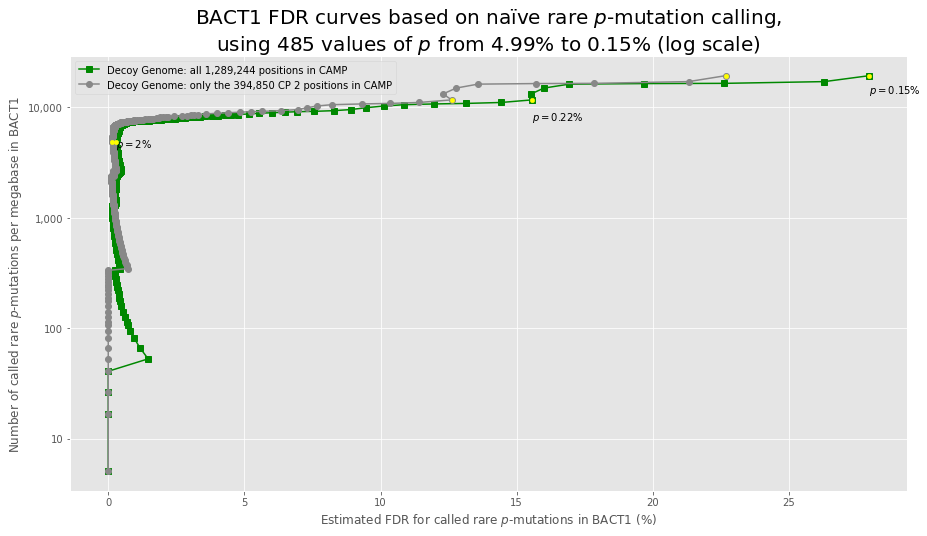

In [17]:
plot_bact1_fdr(
    bact1_naive_p2numpermb,
    (camp_naive_p2numpermb, camp_cp2_naive_p2numpermb),
    (DECOY_CAMP_COLOR, DECOY_CAMP_CP2_COLOR),
    ("s", "o"),
    (
        f"Decoy Genome: all {seq2len['edge_6104']:,} positions in {seq2name['edge_6104']}",
        f"Decoy Genome: only the {num_camp_cp2_pos:,} CP 2 positions in {seq2name['edge_6104']}",
    ),
    "BACT1_FDR_CAMP_decoy",
    show_p_labels=True
)

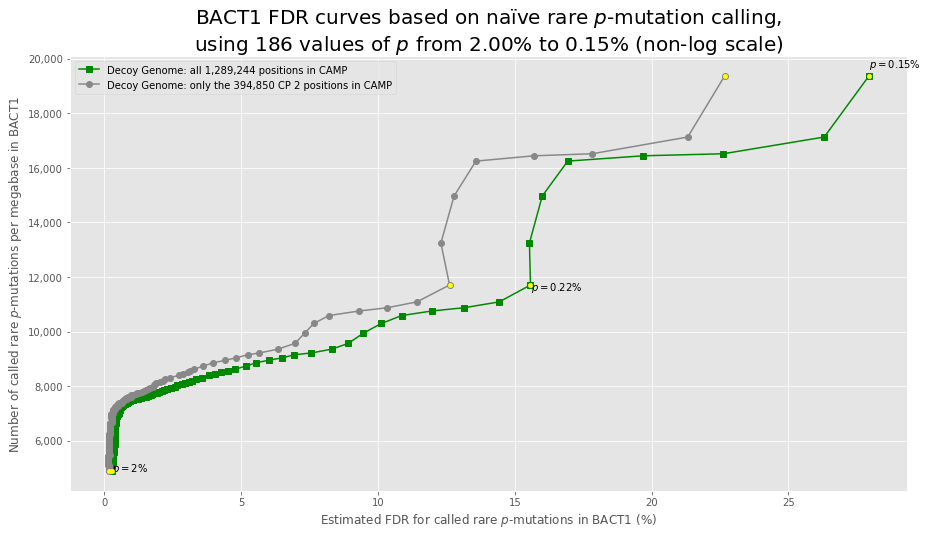

In [18]:
# plot_bact1_fdr(
#     (camp_naive_p2numpermb, camp_cp2_naive_p2numpermb),
#     ("#005500", cp2color[2]),
#     ("s", "o"),
#     (
#         f"Decoy Genome: all {seq2len['edge_6104']:,} positions in {seq2name['edge_6104']}",
#         f"Decoy Genome: only the {num_camp_cp2_pos:,} CP 2 positions in {seq2name['edge_6104']}",
#     ),
#     "BACT1_FDR_CAMP_decoy_max2",
#     start_p=2
# )
plot_bact1_fdr(
    bact1_naive_p2numpermb,
    (camp_naive_p2numpermb, camp_cp2_naive_p2numpermb),
    (DECOY_CAMP_COLOR, DECOY_CAMP_CP2_COLOR),
    ("s", "o"),
    (
        f"Decoy Genome: all {seq2len['edge_6104']:,} positions in {seq2name['edge_6104']}",
        f"Decoy Genome: only the {num_camp_cp2_pos:,} CP 2 positions in {seq2name['edge_6104']}",
    ),
    "BACT1_FDR_CAMP_decoy_nonlog_max2",
    use_log=False,
    start_p=2,
    show_p_labels=True
)

### sanity checking

because the lofreq fdr curve looks weird. but it seems legit.

causal factors for aforementioned weirdness:

- although CAMP CP 2 is strictly smaller (i.e. includes less positions) than all of CAMP, we're not computing the FDR using just raw position counts -- we're using number per mb, so it's possible for CAMP CP 2's FDRs to exceed that of all of CAMP at a fixed value of p.

- the "jumps" seem to correspond to values of p where we pick up new mutations in the decoy genome. Since there are very few of these identified by LoFreq in CAMP / CAMP CP 2, their impact on the graph is very noticeable.

In [19]:
# print("According to LoFreq:")
# for pi in range(500, 400, -1):
#     try:
#         fdr = camp_lofreq_p2numpermb[str(pi / 100)] / bact1_lofreq_p2numpermb[str(pi / 100)]
#     except ZeroDivisionError:
#         fdr = None
#     print(
#         f"At p = {pi / 100}%, CAMP has {camp_lofreq_p2num_called_mutations_i[pi / 100]} rare muts. "
#         f"BACT1 has {bact1_lofreq_p2num_called_mutations_i[pi / 100]} rare muts. "
#         f"FDR est is {fdr}."
#     )

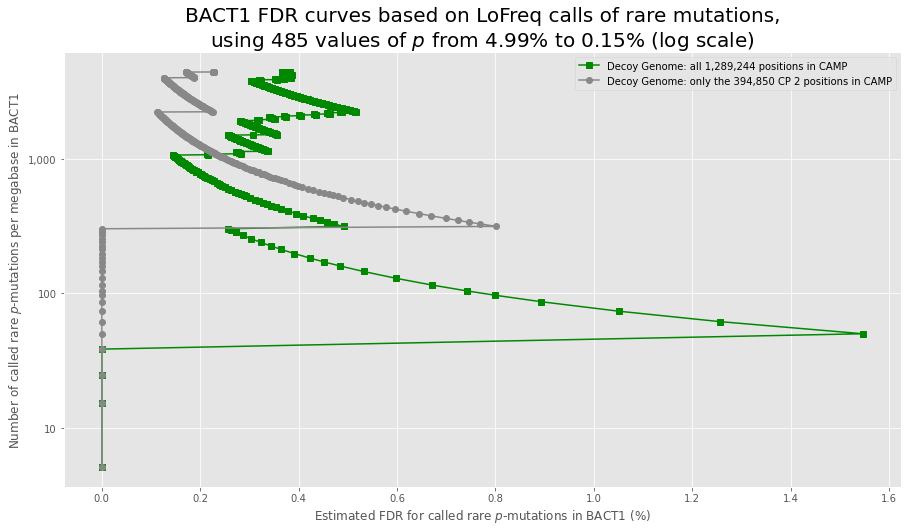

In [20]:
plot_bact1_fdr(
    bact1_lofreq_p2numpermb,
    (camp_lofreq_p2numpermb, camp_cp2_lofreq_p2numpermb),
    (DECOY_CAMP_COLOR, DECOY_CAMP_CP2_COLOR),
    ("s", "o"),
    (
        f"Decoy Genome: all {seq2len['edge_6104']:,} positions in {seq2name['edge_6104']}",
        f"Decoy Genome: only the {num_camp_cp2_pos:,} CP 2 positions in {seq2name['edge_6104']}",
    ),
    "BACT1_FDR_CAMP_decoy_lofreq",
    titleprefix="BACT1 FDR curves based on LoFreq calls of rare mutations",
    special_p_markers=[]
)

## Show how adjusting $p$ adjusts the number of $p$-mutations in a genome (and the FDR, using the T/D approach)

In [19]:
# There is the possibility that we can't compute the FDR for certain values of p -- if a genome has 0 mutations
# for this value of p. In this case, we label these points with a color of None. In order to force matplotlib to
# draw a gray circle for these points, instead of just leaving them blank, we take the default viridis colormap
# and apply the set_bad() method to it to use this gray color. This, in conjunction with the "plotnonfinite"
# argument to scatter(), lets us draw gray circles for values of p with an undefined FDR (see
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html).
viridis_cmap = copy.copy(matplotlib.cm.get_cmap("viridis"))
viridis_cmap.set_bad("#888888")

In [14]:
from matplotlib.ticker import MultipleLocator

In [104]:
seq2p2called_mutations = {
    "edge_6104": camp_naive_p2called_mutations,
    "edge_1671": bact1_naive_p2called_mutations,
    "edge_2358": bact2_naive_p2called_mutations,
    "CAMP CP 2": camp_cp2_naive_p2called_mutations
}

seq2p2numpermb = {
    "edge_1671": bact1_naive_p2numpermb,
    "edge_2358": bact2_naive_p2numpermb,
}

# Used elsewhere, e.g. coverage/length graph component summary
seq2color = {"edge_6104": "#00cc00", "edge_1671": "#ff0000", "edge_2358": "#880088", "CAMP CP 2": "#888888"}

def p_vs_num_muts_plot(leftmost_p=percentages[0], rightmost_p=percentages[-1],
                       fdr_vmin=0, fdr_vmax=100, ylogscale=False, fig_basename=None,
                       scatterplot_kwargs={"zorder": 20, "edgecolors": "#000000"},
                       text2info={}):
    
    # The edgecolor thing is used to give the scatterplot points a black border:
    # see https://stackoverflow.com/a/50707047.
    
    fig, axes = pyplot.subplots(2, 1, gridspec_kw={"hspace": 0.5, "height_ratios": [4, 0.2]})
    
    used_percentages = percentages[percentages.index(leftmost_p):percentages.index(rightmost_p) + 1]
    
    for si, seq in enumerate(["edge_6104", "edge_1671", "edge_2358", "CAMP CP 2"]):
        
        # Reuse the already-called p2called_mutations dicts to save time.
        p2called_mutations = seq2p2called_mutations[seq]
        y = [len(p2called_mutations[str(p)]) for p in used_percentages]
  
        # Two phases: 1) line plot, 2) scatter plot. This lets us color points by FDR.
        axes[0].plot(used_percentages, y, c=seq2color[seq])

        if seq != "edge_6104" and seq != "CAMP CP 2":
            fdrs = []
            for p in used_percentages:
                if seq2p2numpermb[seq][str(p)] > 0:
                    f = 100 * (camp_naive_p2numpermb[str(p)] / seq2p2numpermb[seq][str(p)])
                else:
                    # draw a gray dot for this value of p since we can't compute the FDR (due to the
                    # denominator, i.e. the number of p-mutations per megabase in the "target" genome, being 0)
                    f = None
                fdrs.append(f)
            # https://stackoverflow.com/a/8204981
            # We generate two sc objects (results of calling .scatter()), but we only need one of them: since
            # vmin and vmax are both fixed for both the BACT1 and BACT2 MAGs, the colorbar will be applicable
            # for both.
            sc = axes[0].scatter(
                used_percentages, y, c=fdrs, cmap=viridis_cmap, vmin=fdr_vmin, vmax=fdr_vmax, plotnonfinite=True,
                **scatterplot_kwargs
            )
        else:
            # Plot scatterplot points for CAMP or CAMP CP2,
            # where we can't really estimate a FDR (since we're already using CAMP as a decoy)
            axes[0].scatter(used_percentages, y, c="#888888", **scatterplot_kwargs)
            
    # important to set y scale before calling use_thousands_sep() -- otherwise, the 10^n notation
    # will trump the thousands separator stuff
    if ylogscale:
        axes[0].set_yscale("symlog")
    else:
        # hack hack hack this will break if you use this with other data :S
        # this is done so that we can use the pretty MAG labels for each curve
        axes[0].set_ylim(-4000, 48000)

    use_thousands_sep(axes[0].yaxis)

    # alter the amount of padding used based on the number of percentages we have. Use less padding if
    # there are only a few percentage points shown.
    padding = 1e-4 * len(used_percentages)
    axes[0].set_xlim(leftmost_p + padding, rightmost_p - padding)
    if leftmost_p <= 1:
        axes[0].xaxis.set_major_locator(MultipleLocator(0.1))

    axes[0].set_ylabel("Number of called rare $p$-mutations", fontsize=14)
    axes[0].set_xlabel("Value of $p$ used to call rare $p$-mutations (%)", fontsize=16)

    num_p_vals = len(used_percentages)
    title = f"$p$ vs. number of called rare $p$-mutations: {num_p_vals:,} values of p $\in$ [{leftmost_p:.2f}%, {rightmost_p:.2f}%]"

    # Make it "easy" (well, still involves manual positioning, but eh) to label curves in the plot
    for text in text2info:
        info = text2info[text]
        axes[0].text(info[0], info[1], text, color=info[2], fontweight="semibold")
    
    axes[0].set_title(title, fontsize=20)
    fig.set_size_inches(15, 6)
    
    fig.colorbar(sc, cax=axes[-1], orientation="horizontal")
    
    fdr_desc = ""
    if fdr_vmin != 0:
        fdr_desc = f"FDRs < {fdr_vmin}% are clamped to {fdr_vmin}%; "
    fdr_desc += f"FDRs > {fdr_vmax}% are clamped to {fdr_vmax}%"
    axes[-1].set_xlabel(f"Color scaling applied to BACT1 and BACT2 estimated FDRs (using all of CAMP as a decoy)\n{fdr_desc}", fontsize=14)
    
    if fig_basename is not None:
        fig.savefig(f"figs/{fig_basename}.png", bbox_inches="tight")

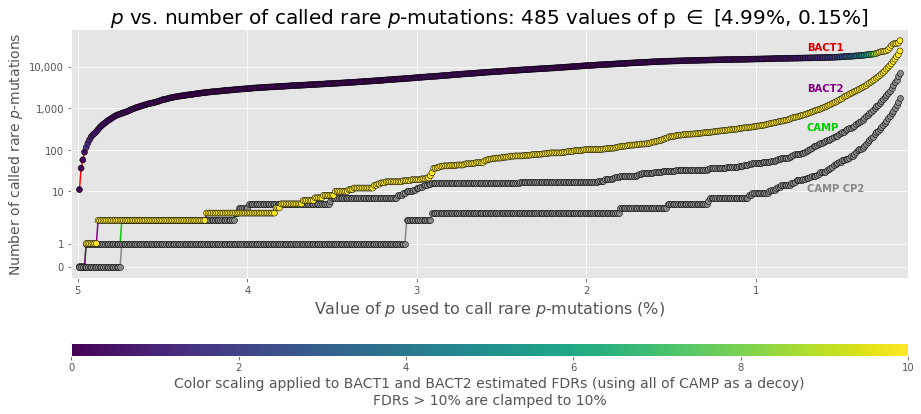

In [124]:
p_vs_num_muts_plot(
    leftmost_p=4.99,
    ylogscale=True, fig_basename="p_vs_num_muts_log_clamp",
    fdr_vmin=0, fdr_vmax=10,
    text2info={
        seq2name['edge_6104']: (0.7, 300, "#00cc00"),
        seq2name['edge_1671']: (0.7, 25000, "#dd0000"),
        seq2name['edge_2358']: (0.7, 2500, seq2color["edge_2358"]),
        "CAMP CP2": (0.7, 10, "#888888"),
    }
)

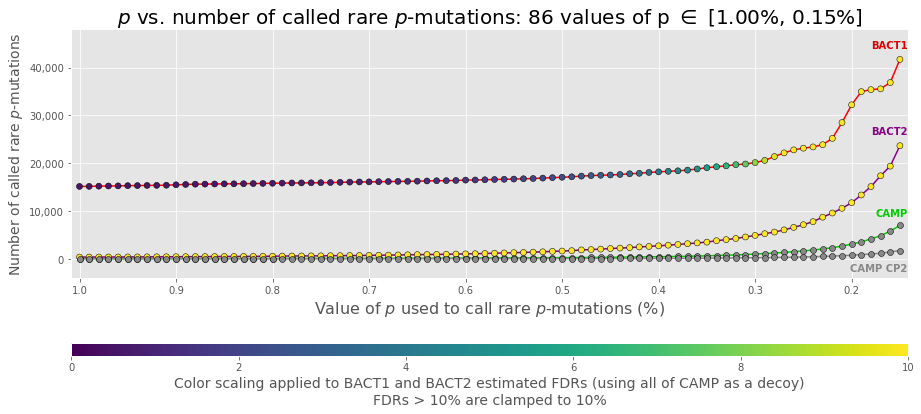

In [107]:
p_vs_num_muts_plot(
    leftmost_p=1,
    ylogscale=False, fig_basename="p_vs_num_muts_nonlog_clamp",
    fdr_vmin=0, fdr_vmax=10,
    text2info={
        seq2name['edge_6104']: (0.175, 9000, "#00cc00"),
        seq2name['edge_1671']: (0.18, 44000, "#dd0000"),
        seq2name['edge_2358']: (0.18, 26000, seq2color["edge_2358"]),
        "CAMP CP2": (0.202, -2500, "#888888"),
    }
)

## FDR curves using nonsynonymous mutation rates and nonsense mutation rates

### Load info about single-nucleotide codon mutations (syn vs nonsyn and non-nonsense vs nonsense) from files

In [26]:
def load_pf(basename):
    with open(f"misc-output/{basename}.pickle", "rb") as pf:
        return pickle.load(pf)

p2seq2obs_si = load_pf("p2seq2obs_si")
p2seq2obs_ni = load_pf("p2seq2obs_ni")
p2seq2obs_nnsi = load_pf("p2seq2obs_nnsi")
p2seq2obs_nsi = load_pf("p2seq2obs_nsi")

seq2poss_si = load_pf("seq2poss_si")
seq2poss_ni = load_pf("seq2poss_ni")
seq2poss_nnsi = load_pf("seq2poss_nnsi")
seq2poss_nsi = load_pf("seq2poss_nsi")

### Compute $R_S$, $R_N$, $R_{NNS}$, $R_{NS}$

In [27]:
# Rates for synonymous and nonsynonymous s.n. mutations
p2seq2synvals = {p: {} for p in percentages}
# Rates for non-nonsense and nonsense s.n. mutations
p2seq2nonsensevals = {p: {} for p in percentages}

for p in percentages:
    for seq in SEQS:
        p2seq2synvals[p][seq] = {}
        # R_S
        p2seq2synvals[p][seq]["syn"] = p2seq2obs_si[p][seq] / seq2poss_si[seq]
        # R_N
        p2seq2synvals[p][seq]["nonsyn"] = p2seq2obs_ni[p][seq] / seq2poss_ni[seq]

        p2seq2nonsensevals[p][seq] = {}
        # R_NNS
        p2seq2nonsensevals[p][seq]["nonnonsense"] = p2seq2obs_nnsi[p][seq] / seq2poss_nnsi[seq]
        # R_NS
        p2seq2nonsensevals[p][seq]["nonsense"] = p2seq2obs_nsi[p][seq] / seq2poss_nsi[seq]

### Misc. text FDR example using nonsynonymous rate

In [39]:
rn_fdr = 100 * (p2seq2synvals[0.5]['edge_1671']['nonsyn'] / 3)
rn_outputtext = (
    f"For the {seq2name['edge_1671']} genome at $p = 0.5\%$, then, "
    r"the FDR would be estimated as $100 \cdot R_N / 3 \approx "
    f"{rn_fdr:.4f}\%$."
)
output_and_print(rn_outputtext, "misc-text/bact1-rs-rn-fdr.tex")

-------------------------------------------------------------------------------
Results that we just output to misc-text/bact1-rs-rn-fdr.tex:
-------------------------------------------------------------------------------
For the BACT1 genome at $p = 0.5\%$, then, the FDR would be estimated as $100 \cdot R_N / 3 \approx 0.0245\%$.


### Misc. text information about BACT2's estimated FDR using a context-dependent target-decoy approach

In [50]:
# just for convenience's sake
c = seq2name['edge_6104']
b1 = seq2name['edge_1671']
b2 = seq2name['edge_2358']

cn = camp_naive_p2numpermb['0.5']
ccp2n = camp_cp2_naive_p2numpermb['0.5']
b2n = bact2_naive_p2numpermb['0.5']

b2_rn_fdr = 100 * (p2seq2synvals[0.5]['edge_2358']['nonsyn'] / 3)
b2_rns_fdr = 100 * (p2seq2nonsensevals[0.5]['edge_2358']['nonsense'] / 3)

bact2fdrinfo = (
    f"Our initially described target-decoy approach estimated a very high FDR for the {b2} MAG:\n"
)
bact2fdrinfo += (
    "at $p = 0.5\%$, NaiveFreq identified "
    f"{round(cn):,} rare mutations per megabase in {c} and "
    f"{round(b2n):,} rare mutations per megabase in {b2}, resulting in an "
    "initial FDR estimate of $\\frac{"
    f"{round(cn):,}"
    "}{"
    f"{round(b2n):,}"
    "}"
    f" \\approx {100 * (cn / b2n):.2f}\\%$.\n"
)
bact2fdrinfo += (
    f"Applying context-dependent target-decoy approaches dramatically decreases "
    f"the estimated FDR of identified mutations in {b2}.\n"
)
bact2fdrinfo += (
    f"Using only the CP2 mutations in CAMP as a decoy genome (with {round(ccp2n):,} mutations per megabase), "
    "we can reduce our FDR estimate to $\\frac{"
    f"{round(ccp2n):,}"
    "}{"
    f"{round(b2n):,}"
    "}"
    f" \\approx {100 * (ccp2n / b2n):.2f}\\%$.\n"
)
bact2fdrinfo += (
    f"Using the ratio of observed to possible nonsynonymous mutations in {b2}, $R_N$, we generate "
    r"a further reduced FDR estimate of $100 \cdot R_N / 3 \approx "
    f"{b2_rn_fdr:.4f}\\%$.\n"
)
bact2fdrinfo += (
    f"The ratio of observed to possible nonsense mutations in {b2}, "
    r"$R_{NS}$, results in a final FDR estimate of $100 \cdot R_{NS} / 3 \approx "
    f"{b2_rns_fdr:.4f}\\%$."
)

output_and_print(bact2fdrinfo, "misc-text/bact2-fdr-varyingdecoy-p0.5.tex")

-------------------------------------------------------------------------------
Results that we just output to misc-text/bact2-fdr-varyingdecoy-p0.5.tex:
-------------------------------------------------------------------------------
Our initially described target-decoy approach estimated a very high FDR for the BACT2 MAG:
at $p = 0.5\%$, NaiveFreq identified 193 rare mutations per megabase in CAMP and 582 rare mutations per megabase in BACT2, resulting in an initial FDR estimate of $\frac{193}{582} \approx 33.21\%$.
Applying context-dependent target-decoy approaches dramatically decreases the estimated FDR of identified mutations in BACT2.
Using only the CP2 mutations in CAMP as a decoy genome (with 132 mutations per megabase), we can reduce our FDR estimate to $\frac{132}{582} \approx 22.64\%$.
Using the ratio of observed to possible nonsynonymous mutations in BACT2, $R_N$, we generate a further reduced FDR estimate of $100 \cdot R_N / 3 \approx 0.0034\%$.
The ratio of observed to po

### Plot (estimated) combined FDR curves

Combining:

- the CAMP naive + CAMP CP 2 decoy genome approaches above
- the nonsyn + nonsense decoy approaches here

At p = 2.0%, 100R_N/3 = 0.015046064691981364 and 100R_NS/3 = 0.00044283400478039306. # p-muts per mb = 4885.311280703857
At p = 1.0%, 100R_N/3 = 0.021963044745748 and 100R_NS/3 = 0.0008856680095607861. # p-muts per mb = 7035.405504055459
At p = 0.5%, 100R_N/3 = 0.02451789991775834 and 100R_NS/3 = 0.001660627517926474. # p-muts per mb = 7926.556867902484
At p = 0.15%, 100R_N/3 = 0.07853276409418154 and 100R_NS/3 = 0.0761674488222276. # p-muts per mb = 19380.104151864452


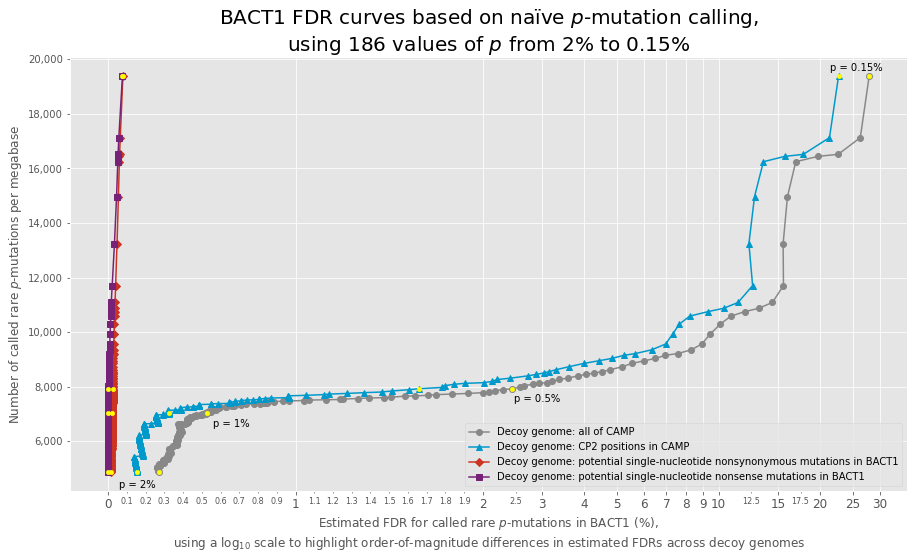

In [29]:
fig, ax = pyplot.subplots(1)

# Highlight the points at these values of p
special_p = [2, 1, 0.5, 0.15]
special_xys = []

# x-axis: Estimated FDR
fdr_naive_campdecoy = []
fdr_cp2_campdecoy = []
fdr_nonsyn = []
fdr_nonsense = []

# y-axis: Number of called p-mutations per megabase
num_called_pmuts_per_mb = []
# (same as above, just omitting the points where y = 0 and we thus can't estimate a FDR. lazy way of ensuring
# the x and y axes are in sync.)
y_naive = []

sn_pcts = [p / 100 for p in range(15, 201, 1)][::-1]

# limit this to starting at 4.99%, since we're only including rare mutations
# but it's weird - not entirely either way. need to decide.
for p in sn_pcts:
    y = bact1_naive_p2numpermb[str(p)]
    num_called_pmuts_per_mb.append(y)
    
    x_n = 100 * (p2seq2synvals[p]["edge_1671"]["nonsyn"] / 3)
    x_ns = 100 * (p2seq2nonsensevals[p]["edge_1671"]["nonsense"] / 3)
    
    fdr_nonsyn.append(x_n)
    fdr_nonsense.append(x_ns)

    if y > 0:
        y_naive.append(y)
        x_naive = 100 * (camp_naive_p2numpermb[str(p)] / y)
        x_cp2 = 100 * (camp_cp2_naive_p2numpermb[str(p)] / y)
        
        fdr_naive_campdecoy.append(x_naive)
        fdr_cp2_campdecoy.append(x_cp2)
    
    if p in special_p:
        print(f"At p = {p}%, 100R_N/3 = {x_n} and 100R_NS/3 = {x_ns}. # p-muts per mb = {y}")
        special_xys.append((x_n, y))
        special_xys.append((x_ns, y))
        if y > 0:
            special_xys.append((x_naive, y))
            special_xys.append((x_cp2, y))
            
        if p == 2: dx = -0.21; dy = -600
        if p == 1: dx = 0.03; dy = -500
        if p == 0.5: dx = 0.03; dy = -500
        if p == 0.15: dx = -6.5; dy = 200
            
        # EXTREMELY lazy way of formatting the special values of p. i'm sure there's a better
        # way to do this in practice but this gets the job done.
        if p == 2 or p == 1:
            s = f"p = {int(p)}%"
        elif p == 0.5:
            s = f"p = {p:.1f}%"
        else:
            s = f"p = {p:.2f}%"
        ax.text(x_naive + dx, y + dy, s)
              
ax.plot(fdr_naive_campdecoy, y_naive, marker="o", color="#888888",
        label=f"Decoy genome: all of {seq2name['edge_6104']}")

ax.plot(fdr_cp2_campdecoy, y_naive, marker="^", color="#0099cc",
        label=f"Decoy genome: CP2 positions in {seq2name['edge_6104']}")

ax.plot(fdr_nonsyn, num_called_pmuts_per_mb, marker="D", color="#cc3322",
        label=f"Decoy genome: potential single-nucleotide nonsynonymous mutations in {seq2name['edge_1671']}")

# We darken the color representing nonsense (NS) mutations from the NNS / NS bar plot, in order to make it
# contrast better with the color representing nonsynonymous (N) mutations
ax.plot(fdr_nonsense, num_called_pmuts_per_mb, marker="s", color="#772277",
        label=f"Decoy genome: potential single-nucleotide nonsense mutations in {seq2name['edge_1671']}")
        
ax.scatter([xy[0] for xy in special_xys], [xy[1] for xy in special_xys], color="#ffff00", zorder=2000, s=20)
    
ax.set_xlabel(
    f"Estimated FDR for called rare $p$-mutations in {seq2name['edge_1671']} (%),\n"
    r"using a log$_{10}$ scale to highlight order-of-magnitude differences in estimated FDRs across decoy genomes"
)

ax.set_ylabel("Number of called rare $p$-mutations per megabase")
maxps = f"{max(sn_pcts):.0f}%"
minps = f"{min(sn_pcts):.2f}%"
title = (
    f'BACT1 FDR curves based on na\u00efve $p$-mutation calling,\nusing {len(sn_pcts):,} values of '
    f'$p$ from {maxps} to {minps}'
)
ax.set_xscale("symlog")
ax.set_xticks([x / 10 for x in range(1, 20)] + [2.5, 12.5, 17.5], minor=True)
ax.set_xticks([0,1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30])

# variant of use_thousands_sep() that doesn't give a weird numpy int64 error about is_integer()
ff = matplotlib.ticker.FuncFormatter(
    lambda x, pos: "{:,}".format(int(x)) if type(x) == int else "{:,}".format(x)
)
ax.xaxis.set_major_formatter(ff)
ax.xaxis.set_minor_formatter(ff)
# Adjust the x-axis tick font sizes: https://stackoverflow.com/a/11386056 (yanked from div idx ntbk)
ax.tick_params(axis="x", which="major", labelsize=12)
ax.tick_params(axis="x", which="minor", labelsize=8)

ax.set_title(title, fontsize=20)
ax.legend()
use_thousands_sep(ax.yaxis)
fig.set_size_inches(15, 8)
fig.savefig(f"figs/bact1_fdr_curves.png", bbox_inches="tight")